# Compare Several Models

## Import packages

In [1]:
import pandas as pd
import numpy as np

from warnings import simplefilter
simplefilter('ignore')

## Data Preparation

In [2]:
data = pd.Series(np.cumsum(np.random.normal(0, 1, size=1000)), 
                 index=pd.date_range(end='31/12/2022', periods=1000)).rename('y').to_frame()
data.head(2)

,y
2020-04-06,-0.253177
2020-04-07,-1.825006


<Axes: >

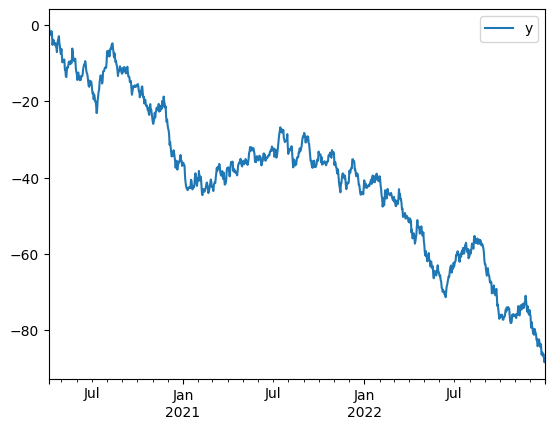

In [3]:
data.plot()

## Section1: Difinir la liste des modeles a comparer

### Option 1 : List of Models from a LiquidityForecast Object List
Default choice if you have already estimated models and wish to compare them without re-estimating.
```python
import pickle
LF_list= []
for f in ['forecaster1.pkl', 'forecaster2.pkl', 'forecaster3.pkl']:
    with open(f, 'rb') as file:
        LF_list.append(pickle.load(file))
    
model = lfs.LiquidityForecastModelSelect(LF_list= LF_list)
```

### Option 2: List of Models from a dictionary
Default choice if you want to reestimate the models

In [4]:
# models necessary to define the forecasting models 
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS, 
    StatsForecastAutoTheta
)
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet

In [5]:
ForecastingModels = {
    "Naive": NaiveForecaster(),
    "AutoARIMA": StatsForecastAutoARIMA(),
    "AutoETS": StatsForecastAutoETS(),
    "AutoTheta": StatsForecastAutoTheta(),
    "TBATS": TBATS(),
    "Prophet": Prophet(),
}

In [6]:
from forecast_ar.model_select import ForecastModelSelect
model = ForecastModelSelect(
            data= data,
            depvar_str = 'y',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 25,
            models_d = ForecastingModels,
            freq = 'B',
            mode = 'nbest_average_horizon',
            score = 'RMSE', 
            nbest = 2)

## Section 2: Evaluate the model OOS

In [7]:
summary_horizon, summary_results = model.evaluate()


Start forecaster Naive evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.006 minutes

Start forecaster AutoARIMA evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.257 minutes

Start forecaster AutoETS evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.359 minutes

Start forecaster AutoTheta evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.219 minutes

Start forecaster TBATS evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel


14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing


Evaluation time: 0.843 minutes

Start forecaster Prophet evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel


14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing
14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluation time: 0.029 minutes


In [8]:
summary_horizon

Naive           AutoARIMA             AutoETS           AutoTheta  \
             RMSE      MAPE      RMSE      MAPE      RMSE      MAPE      RMSE   
horizon                                                                         
1        0.986270  0.012504  1.053019  0.013193  1.020297  0.012905  1.039470   
2        1.073971  0.012754  1.167492  0.014004  1.071367  0.013560  1.153430   
3        1.862403  0.026211  1.827001  0.024915  1.744147  0.024211  1.842973   
4        2.484381  0.034375  2.220268  0.031840  2.217785  0.030906  2.289233   
5        3.089062  0.040572  2.775343  0.037459  2.793197  0.036255  2.862206   
6        3.591063  0.046282  3.130722  0.041797  3.233892  0.041134  3.253064   
7        3.761184  0.049785  3.394800  0.045548  3.443876  0.043745  3.500837   
8        3.500638  0.046821  2.998948  0.041931  3.055749  0.039949  3.130550   
9        4.827942  0.063912  4.303898  0.058671  4.366969  0.056272  4.441960   
10       4.919671  0.061911  4.233568  0.056042  4.331756  0.053493  4.401511   

                      TBATS             Prophet            
             MAPE      RMSE      MAPE      RMSE      MAPE  
horizon                                                    
1        0.013076  1.030824  0.013209  4.223247  0.053623  
2        0.013901  1.181646  0.014718  4.497611  0.061969  
3        0.025251  1.884706  0.026838  5.085417  0.071978  
4        0.032645  2.356428  0.033855  5.020506  0.074085  
5        0.038442  2.990550  0.039895  5.309852  0.077848  
6        0.042955  3.402862  0.044667  5.643671  0.081258  
7        0.046877  3.711270  0.048859  6.464898  0.090632  
8        0.043457  3.383524  0.045743  5.981629  0.083201  
9        0.060322  4.753453  0.062796  6.923088  0.092470  
10       0.057886  4.714734  0.060663  6.548794  0.088554

In [9]:
summary_results

,Naive,AutoARIMA,AutoETS,AutoTheta,TBATS,Prophet
Number of Folds,7,7,7,7,7,7
Avg Fit time (s),0.002078,2.022322,2.985928,1.823773,7.204911,0.179282
Avg_pred_time (s),0.033324,0.170823,0.074318,0.041945,0.006198,0.05514
Smallest training window,536,536,536,536,536,536
Largest training window,686,686,686,686,686,686
First cutoff,2022-04-25 00:00:00,2022-04-25 00:00:00,2022-04-25 00:00:00,2022-04-25 00:00:00,2022-04-25 00:00:00,2022-04-25 00:00:00
Last cutoff,2022-11-21 00:00:00,2022-11-21 00:00:00,2022-11-21 00:00:00,2022-11-21 00:00:00,2022-11-21 00:00:00,2022-11-21 00:00:00
Avg MAPE,0.039513,0.03654,0.035243,0.037481,0.039124,0.077562
Avg RMSE,3.068123,2.786668,2.719274,2.866172,2.989013,5.191834


## Section 3: Select the best model

In [10]:
model.select_best(score = 'MAPE')

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,Naive,Naive,AutoETS,AutoETS,AutoETS,AutoETS,AutoETS,AutoETS,AutoETS,AutoETS
Best_2,AutoETS,AutoETS,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA
Best_3,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta
Best_4,AutoARIMA,AutoARIMA,Naive,TBATS,TBATS,TBATS,TBATS,TBATS,TBATS,TBATS
Best_5,TBATS,TBATS,TBATS,Naive,Naive,Naive,Naive,Naive,Naive,Naive
Best_6,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet


In [11]:
model.avg_oos_horizon['MAPE']

,Naive,AutoARIMA,AutoETS,AutoTheta,TBATS,Prophet,Model Avg (all models),Best 2 Model (over all),Best 2 Model (per horizon)
horizon,,,,,,,,,
1,0.012504,0.013193,0.012905,0.013076,0.013209,0.053623,0.019752,0.013049,0.012704
2,0.012754,0.014004,0.013560,0.013901,0.014718,0.061969,0.021818,0.013782,0.013157
3,0.026211,0.024915,0.024211,0.025251,0.026838,0.071978,0.033234,0.024563,0.024563
4,0.034375,0.031840,0.030906,0.032645,0.033855,0.074085,0.039618,0.031373,0.031373
5,0.040572,0.037459,0.036255,0.038442,0.039895,0.077848,0.045078,0.036857,0.036857
6,0.046282,0.041797,0.041134,0.042955,0.044667,0.081258,0.049682,0.041465,0.041465
7,0.049785,0.045548,0.043745,0.046877,0.048859,0.090632,0.054241,0.044646,0.044646
8,0.046821,0.041931,0.039949,0.043457,0.045743,0.083201,0.050184,0.040940,0.040940
9,0.063912,0.058671,0.056272,0.060322,0.062796,0.092470,0.065740,0.057471,0.057471


<Axes: title={'center': 'Out of Sample Performance'}, ylabel='RMSE'>

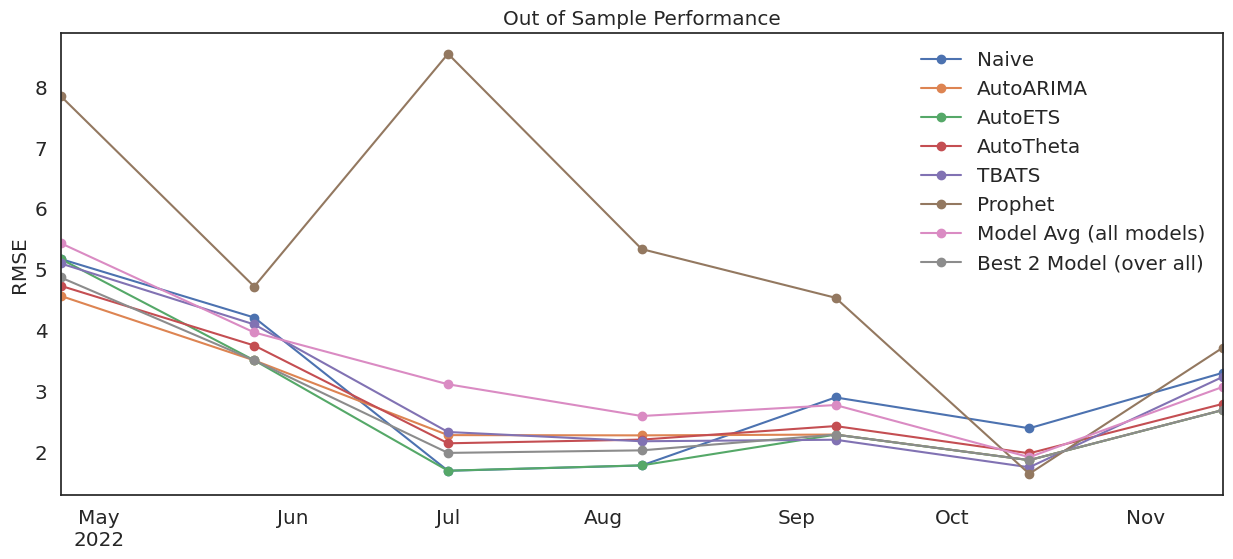

In [12]:
model.plot_model_compare(
    score ='RMSE',
    view = 'cutoff',
    xlabel = '')

<Axes: title={'center': 'Out of Sample Performance'}, xlabel='Horizon', ylabel='RMSE'>

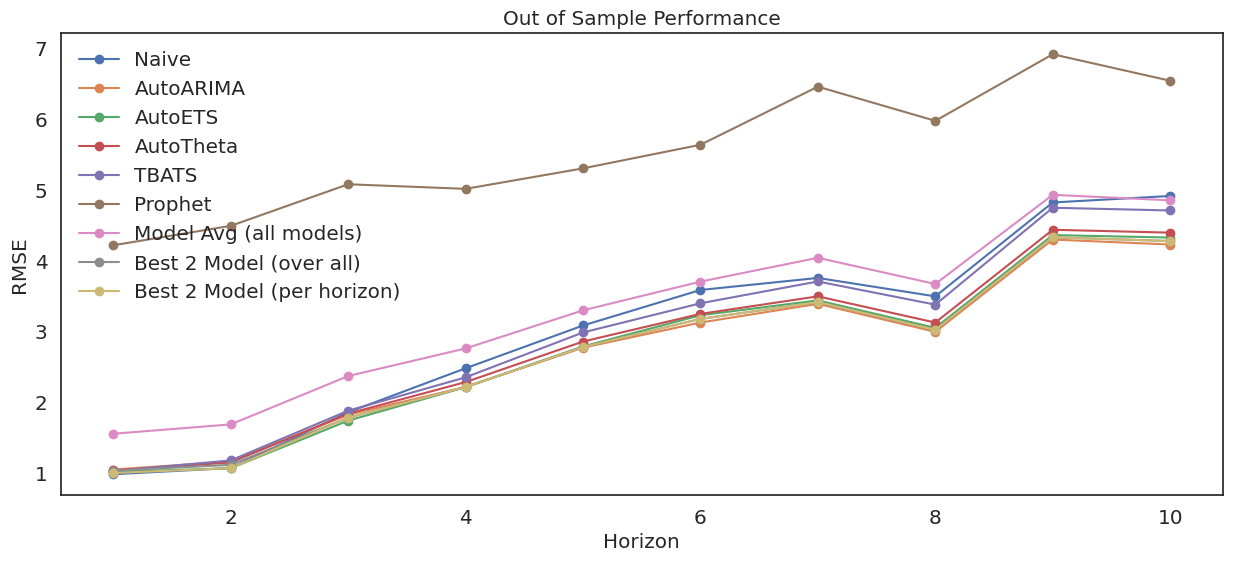

In [13]:
model.plot_model_compare(
    score ='RMSE',
    view = 'horizon',
    xlabel = 'Horizon')

## Section 4 : Generate Predictions
The prediction aggregate the single models predictions is several ways:
* 'best': The prediction is based on the best model.
* 'best_horizon': The prediction is based on the best model for each horizon.
* 'average': The average of the prediction of all models.
* 'inverse_score': The weighted average prediction, where weights are inversely proportional to the model performance score.
* 'nbest_average': Average of the n best models. The n is given by the parameter nbest.
* 'nbest_average_horizon': Average of the n best models for each horizon. The n is given by the parameter nbest.


Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...

Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...

Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...

Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...

Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...


14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing



Model not fitted yet, or fitted on training sample alone
Fitting the model on the whole sample ...


(<Figure size 1500x600 with 1 Axes>, <Axes: title={'center': 'Prediction'}>)

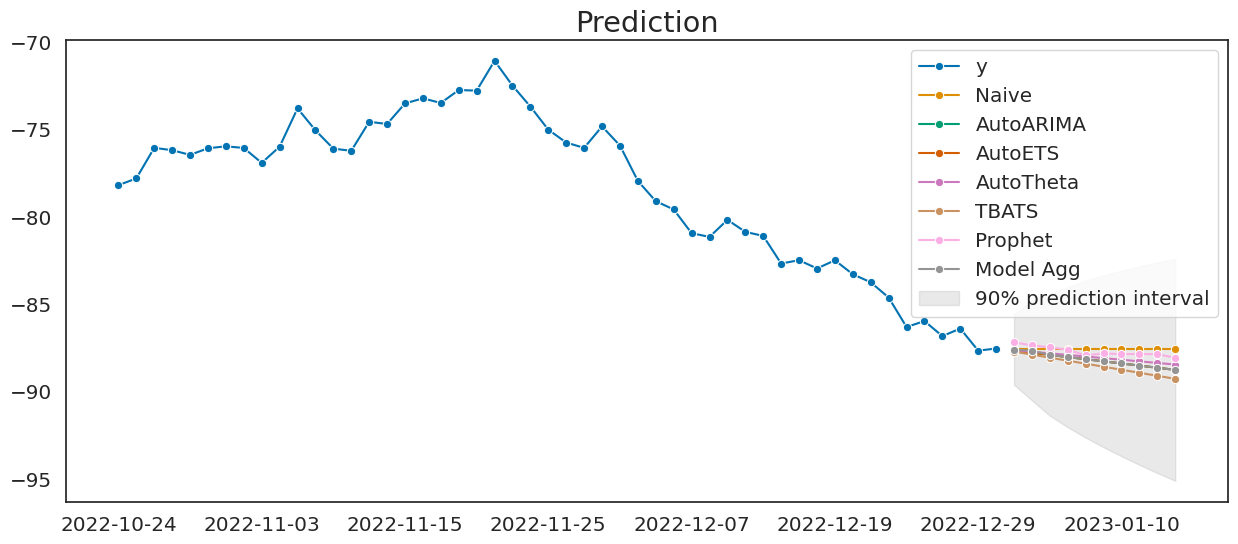

In [14]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(ret_underlying=True)
model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)  

(<Figure size 1500x600 with 1 Axes>, <Axes: title={'center': 'Prediction'}>)

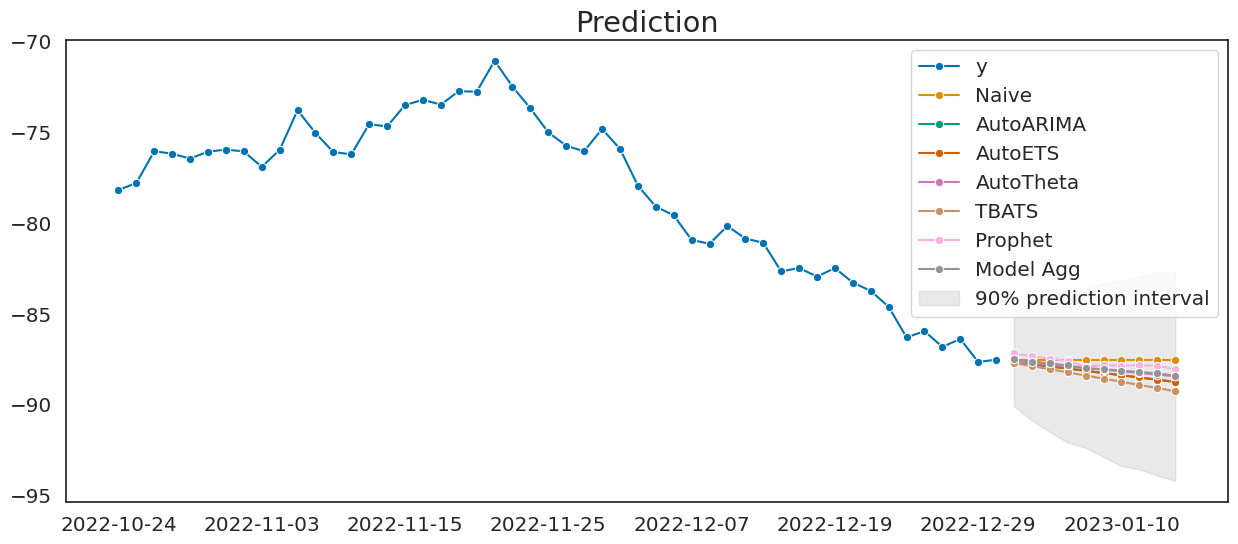

In [15]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='inverse_score', ret_underlying=True)
model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)    

## Section 5: Update data and regenerate the model

In [16]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()

(<Figure size 1500x600 with 1 Axes>, <Axes: title={'center': 'Prediction'}>)

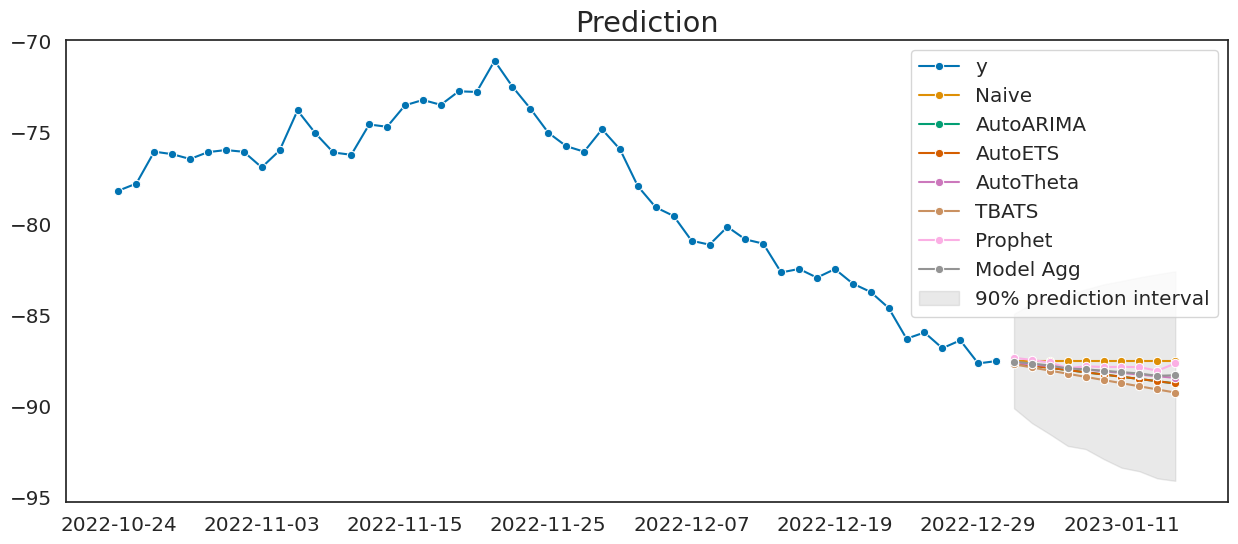

In [17]:
y_pred, y_pred_ints, preds, pred_ints = model.update(newdata=newdata, mode='inverse_score', ret_underlying=True)
model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)    